# 4 Modeling <a id="modeling"></a>

## 4.1 Contents <a id="contents"></a>

- [4 Modeling](#modeling)
  - [4.1 Contents](#contents)
  - [4.2 Introduction](#introduction)
      - [4.2.1 Objective](#objective)
  - [4.3 Imports](#imports)
  - [4.4 Load the Data](#dataload)
  - [4.5 Initial Average Model](#initial)
  - [4.6 Metrics](#metrics)
  - [4.7 Models](#models)
     - [4.7.1 Linear Model](#linear)
     - [4.7.2 Random Forest](#randomforest)
     - [4.7.3 Gradient Boosting](#gbm)
     - [4.7.4 Decision Trees](#trees)
   - [4.8 Hyperparameter Tuning](#hyperparameter)
       - [4.8.1 Random Forest Model Hyperparameter Tuning](#rf_model_hyperparameter)
       - [4.8.2 Features Amount Experiments](#features_experiments)
       - [4.8.3 Retune Hyperparameters with Reduced Feature Set](#hyperparameter_reduced_features)
   - [4.9 Best Model](#bestmodel)
   - [4.10 Summary](#summary)

## 4.2 Introduction <a id="introduction"></a>

In this fourth stage, we'll take our preprocessed data from our preprocessing notebook (stage 3) and try different models to see which model yields the best performance, and tune our hyperparameters for maximizing these results. 

### 4.2.1 Objective <a id="objective"></a>

Our goal is to create and identify the optimal model that most accurately predicts test scores on a per-school district basis for the state of Texas. We've previously conducted a thorough cleaning of our initial datasets gleaned primarily from the Texas Education Agency website, explored and visualized our data, and then did some preprocessing and training for establishing a dataset ready for our models to train on. 

## 4.3 Imports <a id="imports"></a>

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install featuretools

Note: you may need to restart the kernel to use updated packages.


In [22]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy.stats as stats
import matplotlib.ticker as tick
import sklearn.model_selection

from operator import itemgetter
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import (GradientBoostingRegressor, GradientBoostingClassifier)
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

import featuretools as ft
from sklearn import neighbors, datasets, preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

class style:
   BOLD = '\033[1m'
   END = '\033[0m'

## 4.4 Load the Data <a id="dataload"></a>

In [23]:
X_train = pd.read_csv('/Users/joshuabe/Downloads/Capstone 2 - Student Success Prediction/X_train.csv')
X_test = pd.read_csv('/Users/joshuabe/Downloads/Capstone 2 - Student Success Prediction/X_test.csv')
y_train = pd.read_csv('/Users/joshuabe/Downloads/Capstone 2 - Student Success Prediction/y_train.csv')
y_test = pd.read_csv('/Users/joshuabe/Downloads/Capstone 2 - Student Success Prediction/y_test.csv')

In [24]:
# Confirm correct loading
print(X_train.head())
print(y_train.head())

   district_id  estimated_children_in_poverty_5_17  estimated_population_5_17  \
0    -1.641873                           -0.198844                  -0.254862   
1     0.736031                           -0.213093                  -0.218736   
2    -1.102715                            0.223940                   1.045989   
3    -1.158030                           -0.237753                  -0.304382   
4     0.390427                           -0.275291                  -0.335225   

   property_value_per_attended_student  property_value_per_enrolled_student  \
0                            -0.362515                            -0.367949   
1                            -0.116232                            -0.120252   
2                            -0.022461                            -0.009145   
3                            -0.354641                            -0.358926   
4                             0.000256                            -0.006346   

   dist_allr_grad  dist_allr_drop  par

## 4.5 Initial Average Model <a id="initial"></a>

In [25]:
# Calculate the mean of y_train
y_train_mean = y_train['above_tsi_both_rate'].mean()

# Predict the same mean for all test instances
y_pred_baseline = np.full(shape=y_test.shape, fill_value=y_train_mean)

# Compute baseline model performance
baseline_mse = mse(y_test, y_pred_baseline)
baseline_r2 = r2(y_test, y_pred_baseline)

print(f'Baseline Model MSE: {baseline_mse}')
print(f'Baseline Model R^2: {baseline_r2}')

Baseline Model MSE: 250.7151736340615
Baseline Model R^2: -0.0009366522863121229


## 4.6 Metrics <a id="metrics"></a>

- Our metrics will be: 
     - **R-Squared (R²)**: Higher values are better. Indicates a model's ability to explain the variability of the target variable.
     - **Mean Absolute Error (MAE)**: Lower values are better. Average of the absolute differences between predictions and actual observations. It gives an idea of how wrong the predictions were, without considering direction. 
     - **Mean Squared Error (MSE)**: Lower values are better. Measures the average squared difference between the estimated values and the actual value. 
     - **Root Mean Squared Error (RMSE)** Lower values are better. The square root of the MSE. Measures the average magnitude of the error. Especially useful when large errors are particularly undesirable. The square root allows for interpreting the errors in the same units as the response variable. 
     - **Mean Absolute Percentage Error (MAPE)**: Lower values are better. Expresses accuracy as a percentage; calculated as the average of the absolute percentage errors. Provides a perspective of error relative to the size of the numbers involved. 

These metrics will help us determine not only how close the predictions are to the actual data in terms of error magnitude, but also in terms of the proportion of variance explained by the model. 

In addition, during our cross-validation step for each model, we'll use **Cross-Validation Mean MSE (CV Mean MSE)**: Lower values are better, as they indicate better model performance across different subsets of the training data, suggesting better generalization.

## 4.7 Models <a id="models"></a>

We'll try four different models and evaluate the performance of each to find the best one. We'll also perform cross-validation to evaluate how well a model is likely to perform on unseen data by using different subsets of the training data for both training and validation. 

### 4.7.1 Linear Model <a id="linear"></a>

Linear regression is ideal for our initial attempt due to its simplicity and efficiency. We'll then compare the performance of simpler vs more complex models incrementally. 

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Setup for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)  

# Perform cross-validation and calculate the negative MSE
cv_scores = cross_val_score(linear_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Convert the scores to positive and calculate the mean
cv_mean_mse = -cv_scores.mean()
print(f'CV Mean MSE for Linear Regression: {cv_mean_mse}')

# Fit the model on training data
linear_model.fit(X_train, y_train)

# Predict on test data
y_pred_linear = linear_model.predict(X_test)

CV Mean MSE for Linear Regression: 158.42613284442564


In [27]:
# Evaluate the model
mse_linear = mse(y_test, y_pred_linear)
r2_linear = r2(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mae(y_test, y_pred_linear)
mape_linear = np.mean(np.abs((y_test - y_pred_linear) / y_test)) * 100

print(f'Linear Model MSE: {mse_linear}')
print(f'Linear Model R^2: {r2_linear}')
print(f'Linear Model RMSE: {rmse_linear}')
print(f'Linear Model MAE: {mae_linear}')
print(f'Linear Model MAPE: {mape_linear}%')

Linear Model MSE: 137.9798021257943
Linear Model R^2: 0.4491396782210665
Linear Model RMSE: 11.746480414396233
Linear Model MAE: 9.195957007069907
Linear Model MAPE: 48.57929966181877%


### 4.7.2 Random Forest <a id="randomforest"></a>

Next, we'll try a Random Forest model, which is an ensemble method that can handle both non-linear relationships and interactions between features. 

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

# Initialize the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Setup for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and print the mean results
cv_scores = cross_val_score(random_forest_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Convert the scores to positive and calculate the mean
cv_mean_mse = -cv_scores.mean()
print(f'CV Mean MSE for Random Forest: {cv_mean_mse}')

# Fit the model on training data
random_forest_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = random_forest_model.predict(X_test)

# Select the first column as a Series, effectively making it one-dimensional to match y_pred_rf
y_test = y_test.iloc[:, 0]

CV Mean MSE for Random Forest: 134.0907203643448


In [29]:
# Evaluate the model
mse_rf = mse(y_test, y_pred_rf)
r2_rf = r2(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mae(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print(f'Random Forest MSE: {mse_rf}')
print(f'Random Forest R^2: {r2_rf}')
print(f'Random Forest RMSE: {rmse_rf}')
print(f'Random Forest MAE: {mae_rf}')
print(f'Random Forest MAPE: {mape_rf}%')

Random Forest MSE: 115.33459556777777
Random Forest R^2: 0.5395467202599201
Random Forest RMSE: 10.739394562440555
Random Forest MAE: 8.42035
Random Forest MAPE: 43.987194524892374%


### 4.7.3 Gradient Boosting <a id="gbm"></a>

Gradient Boosting is a powerful ensemble technique that builds models sequentially, each new model correcting errors made by the previous ones. 

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the Gradient Boosting Regressor
gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Setup for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and print the mean results
cv_scores = cross_val_score(gradient_boosting_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Convert the scores to positive and calculate the mean
cv_mean_mse = -cv_scores.mean()
print(f'CV Mean MSE for Gradient Boosting: {cv_mean_mse}')

# Fit the model on the training data
gradient_boosting_model.fit(X_train, y_train)

# Predict on test data
y_pred_gb = gradient_boosting_model.predict(X_test)

CV Mean MSE for Gradient Boosting: 135.2166897145964


In [31]:
# Evaluate the model
mse_gb = mse(y_test, y_pred_gb)
r2_gb = r2(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mae(y_test, y_pred_gb)
mape_gb = np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100

print(f'Gradient Boosting MSE: {mse_gb}')
print(f'Gradient Boosting R^2: {r2_gb}')
print(f'Gradient Boosting RMSE: {rmse_gb}')
print(f'Gradient Boosting MAE: {mae_gb}')
print(f'Gradient Boosting MAPE: {mape_gb}%')

Gradient Boosting MSE: 115.10302510296961
Gradient Boosting R^2: 0.5404712249975223
Gradient Boosting RMSE: 10.728607789595518
Gradient Boosting MAE: 8.521839739681484
Gradient Boosting MAPE: 44.19977856235523%


### 4.7.4 Decision Trees <a id="trees"></a>

Decision Trees are simpler than the previous models but can be very effective, particularly if the relationship between the features and the target is non-linear and complex. 

In [32]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree Regressor
decision_tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)  

# Setup for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and print the mean results
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Convert the scores to positive and calculate the mean
cv_mean_mse = -cv_scores.mean()
print(f'CV Mean MSE for Decision Tree: {cv_mean_mse}')

# Fit the model on the training data
decision_tree_model.fit(X_train, y_train)

# Predict on test data
y_pred_dt = decision_tree_model.predict(X_test)

CV Mean MSE for Decision Tree: 179.21133415850537


In [33]:
# Evaluate the model
mse_dt = mse(y_test, y_pred_dt)
r2_dt = r2(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mae_dt = mae(y_test, y_pred_dt)
mape_dt = np.mean(np.abs((y_test - y_pred_dt) / y_test)) * 100

print(f'Decision Tree MSE: {mse_dt}')
print(f'Decision Tree R^2: {r2_dt}')
print(f'Decision Tree RMSE: {rmse_dt}')
print(f'Decision Tree MAE: {mae_dt}')
print(f'Decision Tree MAPE: {mape_dt}%')

Decision Tree MSE: 156.86250355797927
Decision Tree R^2: 0.37375378241070845
Decision Tree RMSE: 12.524476178985662
Decision Tree MAE: 9.998448860563231
Decision Tree MAPE: 53.28319690533226%


Looking at all the models, **Random Forest and Gradient Boosting are the top performers based on the metrics**. Both models have similar performance metrics, with **Gradient Boosting slightly edging out in terms of a lower Test MSE and RMSE, and a slightly higher R²**. Their MAE and MAPE are also comparable, and both models demonstrate better generalization ability (lower CV Mean MSE) compared to Linear Regression and Decision Tree.

While Gradient Boosting slightly outperforms Random Forest in some metrics, the differences are not substantial enough to clearly favor one over the other based on performance alone. **Compared to Gradient Boosting, Random Forest is**: 
- **More interpretable**: feature importances are more easily gleaned
- **Less sensitive to overfitting**: this is from the averaging of multiple decision trees 
- **Easier to tune**: this is due to having fewer hyperparameters that critically affect performance

**To balance the need for a high-performing model with the practical considerations of explainability, we'll opt for the Random Forest model** as our best model to use. 

## 4.8 Hyperparameter Tuning <a id="hyperparameter"></a>

We'll now proceed with hyperparameter tuning of our Random Forest model. 

### 4.8.1 Random Forest Model Hyperparameter Tuning <a id="rf_model_hyperparameter"></a>

#### **Step 1: Hyperparameter Tuning with GridSearchCV**

First, let's fine-tune the Random Forest model using GridSearchCV to explore a range of parameter values. 

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Create a parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None]
}

# Define a scoring function
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scorer, cv=5)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print(f'Best parameters found: {grid_search.best_params_}')

Best parameters found: {'max_depth': None, 'n_estimators': 300}


#### **Step 2: Evaluating the Tuned Model**

Now that we've identified the best parameters, we'll evaluate the tuned model on the test data. 

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the test data
y_pred = best_rf.predict(X_test)

# Calculate MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 113.72227194111112
Mean Absolute Error: 8.396278148148149


These metrics are just slightly lower than the MSE and MAE of our initial Random Forest model prior to tuning (115.34752229777779 and 8.420846666666668), which indicates tuning the hyperparameters improved the model by a small margin. 

#### **Step 3: Visualizing Feature Importances**

Now, let's create a bar graph to visualize the feature importances of the tuned Random Forest model. This will provide insights into which features are most influential in predicting the output.

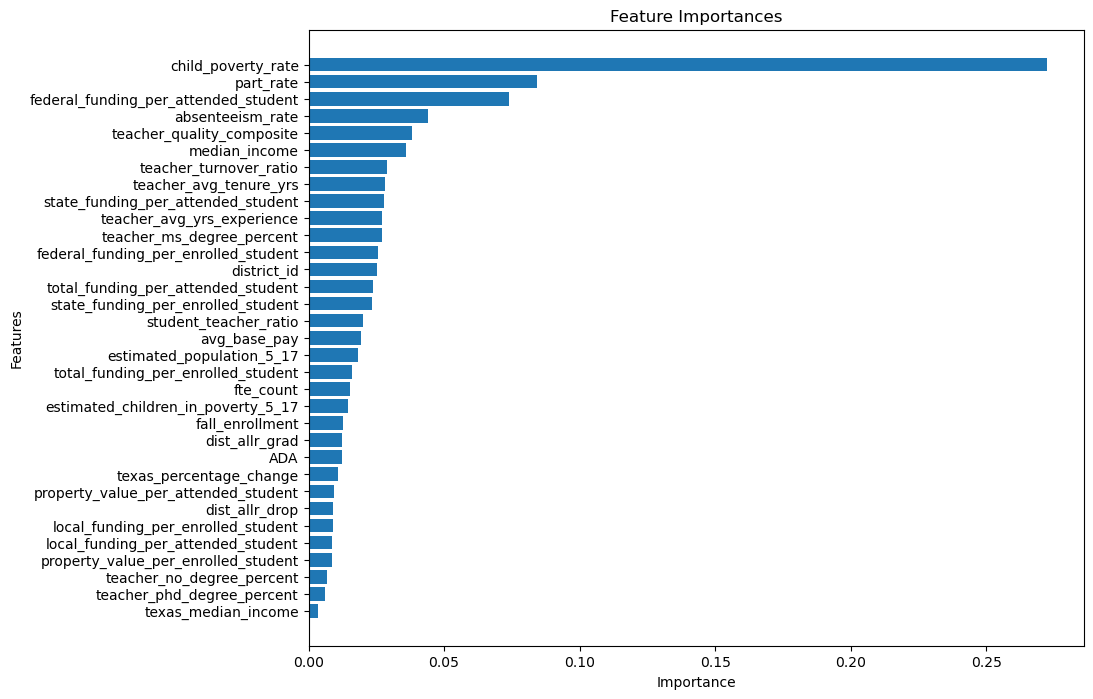

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = best_rf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange the feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create a bar plot
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), names)
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest importance at the top
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

**The graph shows Child Poverty Rate as by far the most important feature for predicting test scores with our model**. There are lots of features here (33 to be exact), and most don't seem to have much relative importance to model predictive accuracy. Let's try experimenting with different feature reductions to see if we can simplify our model without losing too much predictive power. 

### 4.8.2 Features Amount Experiments <a id="features_experiments"></a>

In [37]:
# Experiment 1: 15 Features

from sklearn.feature_selection import RFE

# Initialize the RFE object, using your RF model as the estimator
selector = RFE(estimator=best_rf, n_features_to_select=15, step=1)
selector = selector.fit(X_train, y_train)

# Transform training and test data
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

# Re-fit the model on reduced data and evaluate it
best_rf.fit(X_train_reduced, y_train)
y_pred_reduced = best_rf.predict(X_test_reduced)
print(mean_squared_error(y_test, y_pred_reduced))

113.79725743617286


In [38]:
# Experiment 2: 12 Features

from sklearn.feature_selection import RFE

# Initialize the RFE object, using your RF model as the estimator
selector = RFE(estimator=best_rf, n_features_to_select=12, step=1)
selector = selector.fit(X_train, y_train)

# Transform training and test data
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

# Re-fit the model on reduced data and evaluate it
best_rf.fit(X_train_reduced, y_train)
y_pred_reduced = best_rf.predict(X_test_reduced)
print(mean_squared_error(y_test, y_pred_reduced))

117.88159495185187


In [39]:
# Experiment 3: 10 Features

from sklearn.feature_selection import RFE

# Initialize the RFE object, using your RF model as the estimator
selector = RFE(estimator=best_rf, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)

# Transform training and test data
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

# Re-fit the model on reduced data and evaluate it
best_rf.fit(X_train_reduced, y_train)
y_pred_reduced = best_rf.predict(X_test_reduced)
print(mean_squared_error(y_test, y_pred_reduced))

117.02633929518517


12 features shows the worst MSE of the three experiments. 15 features shows the lowest MSE which is also the same MSE to our original 33 feature model, but using 10 features might be preferable to this if the practical difference between these two model options is negligible.  

In [40]:
original_rmse = np.sqrt(113.80580326333335) # 15 Features Option (same MSE as original 33 features model)
updated_rmse = np.sqrt(117.07754467345679) # 10 Features Option
difference_in_rmse = updated_rmse - original_rmse

print("Original RMSE:", original_rmse)
print("Updated RMSE:", updated_rmse)
print("Difference in RMSE:", difference_in_rmse)

Original RMSE: 10.66798028041547
Updated RMSE: 10.8202377364574
Difference in RMSE: 0.15225745604193008


A difference of 0.15 in the RMSE, which translates to approximately 0.15 point less accuracy per student, is negligible, especially in the context of educational testing where the scores range from 0 to 100. **This slight increase in RMSE suggests that the predictive accuracy of our model has been minimally impacted by the reduction of features.**

Let's revisit the hyperparameter tuning steps with our now reduced set of 10 features. This will ensure that the model is finely tuned to the selected subset of features, potentially yielding different optimal hyperparameter settings than those determined with the full feature set. 

### 4.8.3 Retune Hyperparameters with Reduced Feature Set <a id="hyperparameter_reduced_features"></a>

#### **Step 1: Hyperparameter Tuning with GridSearchCV**

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Create a parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_reduced, y_train)

# Print the best parameters and best score
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best CV score: {-grid_search.best_score_}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score: 135.88744837021227


#### **Step 2: Evaluating the Tuned Model**

In [53]:
# Use the best estimator to make predictions
y_pred = grid_search.best_estimator_.predict(X_test_reduced)

# Calculate performance metrics
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import math

rmse = math.sqrt(mse(y_test, y_pred))

print(f'MSE: {mse(y_test, y_pred)}')
print(f'MAE: {mae(y_test, y_pred)}')
print(f'R^2: {r2(y_test, y_pred)}')
print(f'RMSE: {rmse}')

MSE: 116.90479197315888
MAE: 8.50256817651733
R^2: 0.5332779846638522
RMSE: 10.812251938109789


#### **Step 3: Visualizing Feature Importances**

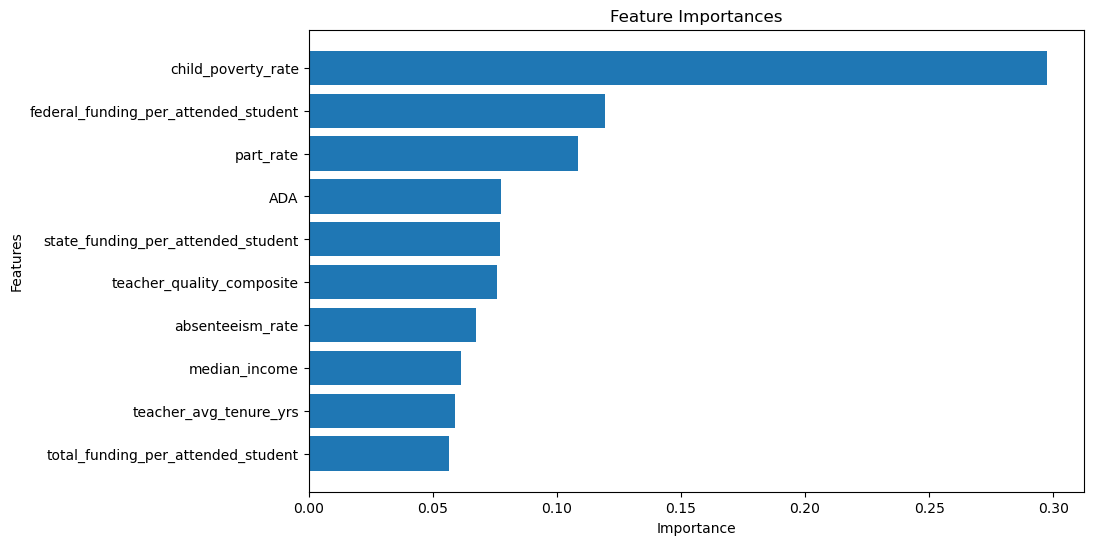

In [43]:
import matplotlib.pyplot as plt
import numpy as np


feature_importances = grid_search.best_estimator_.feature_importances_
# Get the indices of the features that were selected
selected_indices = selector.get_support(indices=True)
# Get the names of the features that were selected
selected_feature_names = X_train.columns[selected_indices]

# Sort the feature importances in descending order and adjust the indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), selected_feature_names[sorted_indices])
plt.gca().invert_yaxis()  # This inverts the plot so the most important are at the top
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## 4.9 Best Model <a id="bestmodel"></a>

In [44]:
from joblib import dump


# grid_search is the GridSearchCV object
best_rf = grid_search.best_estimator_

# Save the optimized and trained Random Forest model
dump(best_rf, 'optimized_random_forest.joblib')

['optimized_random_forest.joblib']

**Our best model was achieved with Random Forest**. We started with tuning hyperparameters on the full 33 features, then narrowed this down to 10 features and re-tuned our hyperparameters using GridSearchCV. Our best parameters that lowered our MSE were: 

- max_depth: 30
- min_samples_leaf: 1
- min_samples_split: 2 
- n_estimators: 300

## 4.10 Summary <a id="summary"></a>

This project involved developing a predictive model for high school standardized test scores on a school district level. We began with our training and testing data from our prior notebook and then evaluated multiple models including Linear Regression, Random Forest, Gradient Boosting, and Decision Tree to determine which yielded the highest performance. 

The **Random Forest model was identified as the best model** through comprehensive evaluation, including cross-validation and hyperparameter tuning. It achieved an MSE of 115.35 on the test set, with a minimal decrease in RMSE (0.15 points) when reduced from the full set of features to the top 10 most important features. After hyperparameter tuning on the reduced feature set, the model achieved an MSE of 116.9, an MAE of 8.5, an R-Squared 0.53, and an RMSE of 10.8. 

The feature importance analysis revealed that **variables such as Child Poverty Rate, Federal Funding Per Attended Student, and Participation Rate (rate of participating in taking standardized tests) are crucial in predicting test scores, emphasizing the impact of socioeconomic factors and resource allocation on educational outcomes**. Teacher Quality and Median Income also showed among the most important predictive variables. 

The final Random Forest model strikes a balance between predictive accuracy and model simplicity, making it suitable for use by both technical and non-technical stakeholders.